In [1]:
import sys
sys.path.append('../')

**Import Module**

In [2]:
import torch.nn as nn
from torchvision import models
import timm

from models.trainer import Trainer
from datasets.data_manager import DataManager
from models.transform_manager import TransformManager
from models.model_manager import ModelManager
from models.training_manager import TrainingManager
from models.test_manager import TestManager

from results.metrics_visualizer import MetricsVisualizer
from results.metrics_calculator import MetricsCalculator
from results.plot_visualizer import PlotVisualizer
from results.heatmap_generator import HeatmapGenerator

**Define Model Class**

In [3]:
class EfficientNetB0MultiLabel(nn.Module):

    def __init__(self, num_classes):
        super(EfficientNetB0MultiLabel, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)

        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

**Define Model Name & Initialize Model Class**

In [4]:
modelName = "EfficientNetB0"
MODEL = EfficientNetB0MultiLabel

**Constants**

In [5]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
SIZE = 224
FOLD_SPLITS=10
EPOCHS = 30
DEVICE = "cuda"
WEIGHT_DECAY = 1e-5
OPTIMIZER_TYPE = "RAdam"

MAIN_CSV_FILE = "../final_label.csv"
LABEL_COLS = ["Fracture", "CalvarialFracture", "OtherFracture"]
DATASET_PATH = "../Dataset_PNG"
TEST_CSV_FILE = "../test_fold.csv"

MODEL_SAVE_PATH = f"./models/{modelName}"
TRAINING_VALIDATION_PLOT_SAVE_PATH = f"./results/{modelName}"
PLOT_SAVE_PATH = f"./results/{modelName}"
GRADCAM_HEATMAP_SAVE_PATH = f"./results/{modelName}"
CAM_OUTPUT_SIZE = 512

***Initialize necessary modules***

In [6]:
data_manager = DataManager(MAIN_CSV_FILE, LABEL_COLS, FOLD_SPLITS)

transform_manager = TransformManager(DATASET_PATH, SIZE, BATCH_SIZE)

model_manager = ModelManager(LABEL_COLS, DEVICE, MODEL_SAVE_PATH, MODEL, LEARNING_RATE, WEIGHT_DECAY, OPTIMIZER_TYPE)

training_manager = TrainingManager(data_manager, transform_manager, model_manager, EPOCHS)

***Begin training***

In [7]:
training_manager.run_training()

Processing Folds:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 51.5662, Train Accuracy: 0.6133, Val Loss: 44.6124, Val Accuracy: 0.7755


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 38.6582, Train Accuracy: 0.8184, Val Loss: 26.0849, Val Accuracy: 0.8891


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 23.5753, Train Accuracy: 0.9011, Val Loss: 14.6846, Val Accuracy: 0.9438


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 14.7372, Train Accuracy: 0.9401, Val Loss: 9.2224, Val Accuracy: 0.9647


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 10.1473, Train Accuracy: 0.9565, Val Loss: 7.1670, Val Accuracy: 0.9731


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 7.0200, Train Accuracy: 0.9719, Val Loss: 4.9124, Val Accuracy: 0.9808


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 5.6769, Train Accuracy: 0.9754, Val Loss: 2.9399, Val Accuracy: 0.9887


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 4.0181, Train Accuracy: 0.9847, Val Loss: 2.6751, Val Accuracy: 0.9908


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 3.2173, Train Accuracy: 0.9872, Val Loss: 2.3961, Val Accuracy: 0.9923


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 2.7045, Train Accuracy: 0.9884, Val Loss: 2.3663, Val Accuracy: 0.9915


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 2.2605, Train Accuracy: 0.9915, Val Loss: 1.8654, Val Accuracy: 0.9938


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 1.9876, Train Accuracy: 0.9928, Val Loss: 1.9480, Val Accuracy: 0.9938


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 2.0364, Train Accuracy: 0.9914, Val Loss: 1.2522, Val Accuracy: 0.9957


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 1.2942, Train Accuracy: 0.9951, Val Loss: 1.4722, Val Accuracy: 0.9957


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 1.3919, Train Accuracy: 0.9947, Val Loss: 1.5093, Val Accuracy: 0.9954


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 1.1648, Train Accuracy: 0.9955, Val Loss: 1.6408, Val Accuracy: 0.9935


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.8445, Train Accuracy: 0.9971, Val Loss: 1.1911, Val Accuracy: 0.9959


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 1.7038, Train Accuracy: 0.9923, Val Loss: 1.8966, Val Accuracy: 0.9934


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 1.9414, Train Accuracy: 0.9921, Val Loss: 0.9452, Val Accuracy: 0.9964


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 1.1653, Train Accuracy: 0.9954, Val Loss: 1.0528, Val Accuracy: 0.9960


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.6680, Train Accuracy: 0.9974, Val Loss: 0.9953, Val Accuracy: 0.9965


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.9345, Train Accuracy: 0.9967, Val Loss: 1.2584, Val Accuracy: 0.9960


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.9057, Train Accuracy: 0.9963, Val Loss: 1.1784, Val Accuracy: 0.9963


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 1.9010, Train Accuracy: 0.9923, Val Loss: 1.3990, Val Accuracy: 0.9945


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.9820, Train Accuracy: 0.9967, Val Loss: 0.9000, Val Accuracy: 0.9969


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.3692, Train Accuracy: 0.9991, Val Loss: 0.8453, Val Accuracy: 0.9969


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.5929, Train Accuracy: 0.9975, Val Loss: 0.7356, Val Accuracy: 0.9969


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.5305, Train Accuracy: 0.9981, Val Loss: 0.9964, Val Accuracy: 0.9965


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.5140, Train Accuracy: 0.9983, Val Loss: 1.2170, Val Accuracy: 0.9959


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.4723, Train Accuracy: 0.9986, Val Loss: 0.8893, Val Accuracy: 0.9963


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 50.7733, Train Accuracy: 0.6466, Val Loss: 43.5599, Val Accuracy: 0.7811


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 38.1891, Train Accuracy: 0.8220, Val Loss: 27.0679, Val Accuracy: 0.8797


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 23.2045, Train Accuracy: 0.9022, Val Loss: 15.6503, Val Accuracy: 0.9348


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 14.2396, Train Accuracy: 0.9444, Val Loss: 10.4631, Val Accuracy: 0.9528


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 9.4414, Train Accuracy: 0.9639, Val Loss: 7.0446, Val Accuracy: 0.9718


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 6.5561, Train Accuracy: 0.9748, Val Loss: 4.7608, Val Accuracy: 0.9802


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 4.8158, Train Accuracy: 0.9809, Val Loss: 3.3609, Val Accuracy: 0.9878


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 3.4414, Train Accuracy: 0.9868, Val Loss: 2.6944, Val Accuracy: 0.9896


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 2.9167, Train Accuracy: 0.9896, Val Loss: 1.7932, Val Accuracy: 0.9941


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 2.2278, Train Accuracy: 0.9925, Val Loss: 1.4672, Val Accuracy: 0.9950


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 1.9637, Train Accuracy: 0.9931, Val Loss: 2.6061, Val Accuracy: 0.9884


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 1.6795, Train Accuracy: 0.9936, Val Loss: 1.1913, Val Accuracy: 0.9955


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 1.8938, Train Accuracy: 0.9918, Val Loss: 1.2300, Val Accuracy: 0.9956


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 1.5154, Train Accuracy: 0.9948, Val Loss: 1.3710, Val Accuracy: 0.9947


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.9456, Train Accuracy: 0.9973, Val Loss: 1.0768, Val Accuracy: 0.9955


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 1.1890, Train Accuracy: 0.9953, Val Loss: 2.0637, Val Accuracy: 0.9907


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 1.1260, Train Accuracy: 0.9963, Val Loss: 1.2597, Val Accuracy: 0.9955


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 1.3011, Train Accuracy: 0.9943, Val Loss: 1.0735, Val Accuracy: 0.9960


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 1.1621, Train Accuracy: 0.9949, Val Loss: 0.7551, Val Accuracy: 0.9970


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 1.1267, Train Accuracy: 0.9952, Val Loss: 0.8295, Val Accuracy: 0.9969


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.5413, Train Accuracy: 0.9982, Val Loss: 0.7230, Val Accuracy: 0.9975


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.6236, Train Accuracy: 0.9981, Val Loss: 0.7515, Val Accuracy: 0.9971


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.5130, Train Accuracy: 0.9983, Val Loss: 0.8966, Val Accuracy: 0.9973


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.9530, Train Accuracy: 0.9957, Val Loss: 0.6778, Val Accuracy: 0.9977


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.5794, Train Accuracy: 0.9974, Val Loss: 0.7984, Val Accuracy: 0.9969


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.8867, Train Accuracy: 0.9951, Val Loss: 1.0726, Val Accuracy: 0.9953


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 2.0901, Train Accuracy: 0.9916, Val Loss: 0.8898, Val Accuracy: 0.9965


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.9082, Train Accuracy: 0.9967, Val Loss: 0.6268, Val Accuracy: 0.9981


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.4441, Train Accuracy: 0.9987, Val Loss: 0.9787, Val Accuracy: 0.9959


Processing Training Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Processing Validation Folds:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.5707, Train Accuracy: 0.9981, Val Loss: 0.8067, Val Accuracy: 0.9973


***Show Training vs Validation Plot***

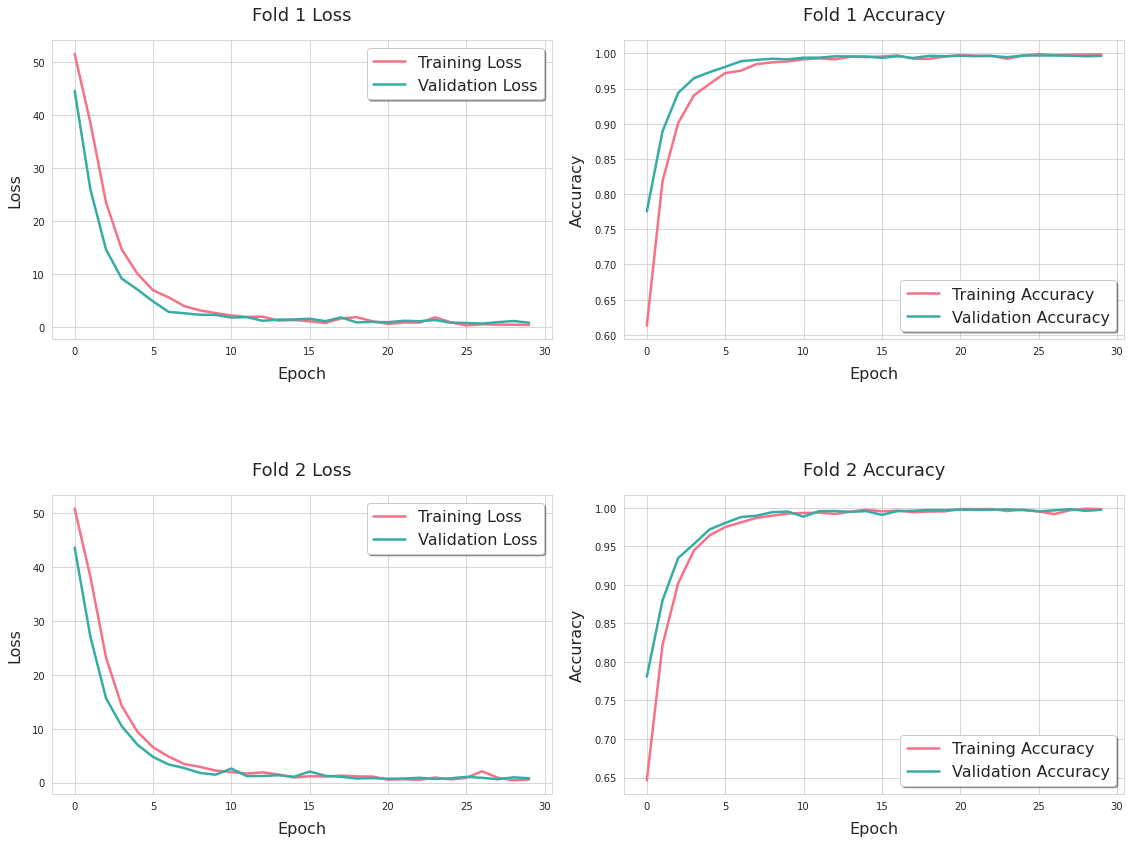

In [8]:
visualizer = MetricsVisualizer(training_manager.train_losses, training_manager.val_losses, training_manager.train_accuracies, training_manager.val_accuracies, TRAINING_VALIDATION_PLOT_SAVE_PATH)
visualizer.plot_metrics()


***Begin Inference***

In [41]:
model_predictor = TestManager(DATASET_PATH, TEST_CSV_FILE, LABEL_COLS, SIZE, MODEL, DEVICE, MODEL_SAVE_PATH, FOLD_SPLITS)

predictions, true_labels, probabilities = model_predictor.make_predictions()

Processing Folds:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Prediction:   0%|          | 0/2468 [00:00<?, ?it/s]

Processing Prediction:   0%|          | 0/2468 [00:00<?, ?it/s]

***Compute and Display Metrics***

In [42]:
metrics_calculator = MetricsCalculator(LABEL_COLS)

aggregated_metrics, metrics_per_class, classification_reports, multi_label_report = metrics_calculator.compute_metrics(predictions[0], true_labels[0])
metrics_calculator.display_metrics(aggregated_metrics, metrics_per_class, classification_reports, multi_label_report)


Aggregated Metrics:
{'accuracy': 0.9977039438141545, 'f1_score': 0.9959574873945671, 'specificity': 0.9998347380598248, 'sensitivity': 0.9926838604722027}

Class-wise Metrics:

Fracture:
{'accuracy': 0.9979740680713128, 'f1_score': 0.9976403964134025, 'specificity': 1.0, 'sensitivity': 0.995291902071563}

CalvarialFracture:
{'accuracy': 0.9975688816855753, 'f1_score': 0.9969135802469136, 'specificity': 1.0, 'sensitivity': 0.9938461538461538}

OtherFracture:
{'accuracy': 0.9975688816855753, 'f1_score': 0.9933184855233853, 'specificity': 0.9995042141794744, 'sensitivity': 0.9889135254988913}

Classification Reports Per Class:

Fracture:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1406
         1.0       1.00      1.00      1.00      1062

    accuracy                           1.00      2468
   macro avg       1.00      1.00      1.00      2468
weighted avg       1.00      1.00      1.00      2468


CalvarialFracture:
          

***Display Plots***

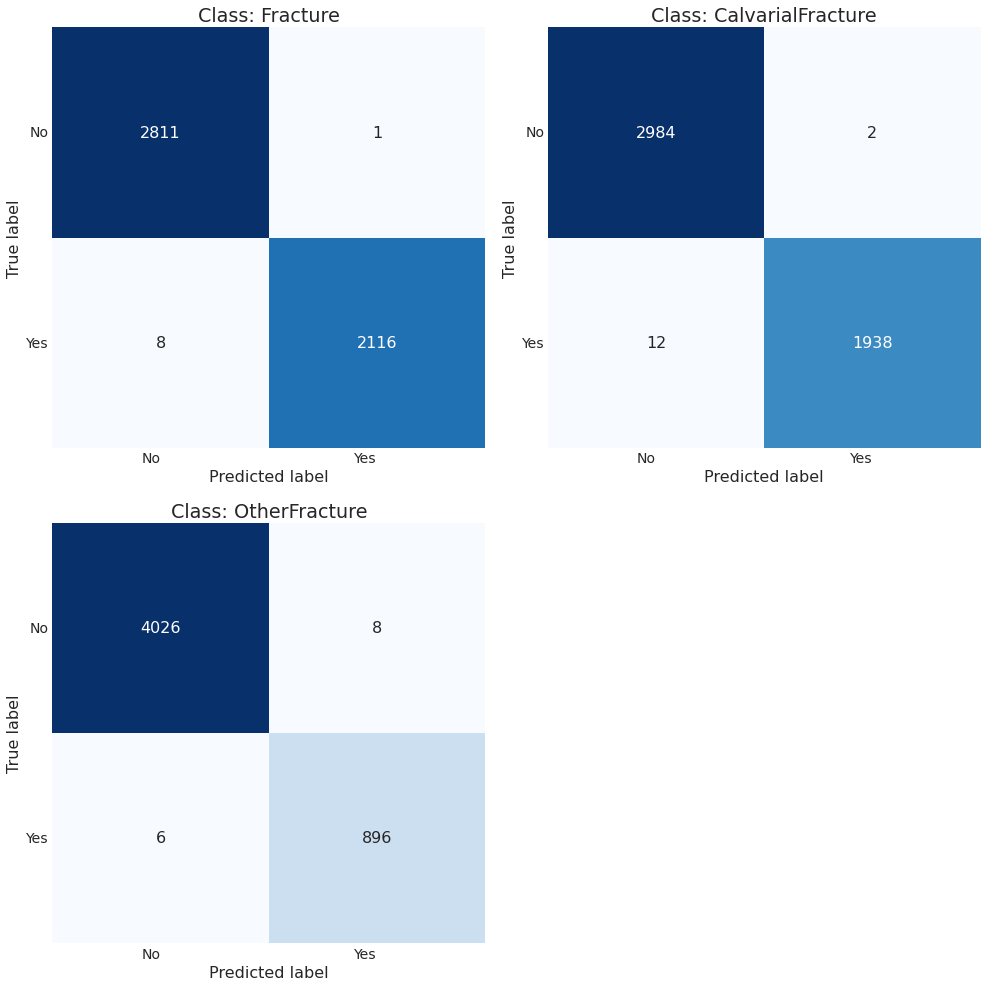

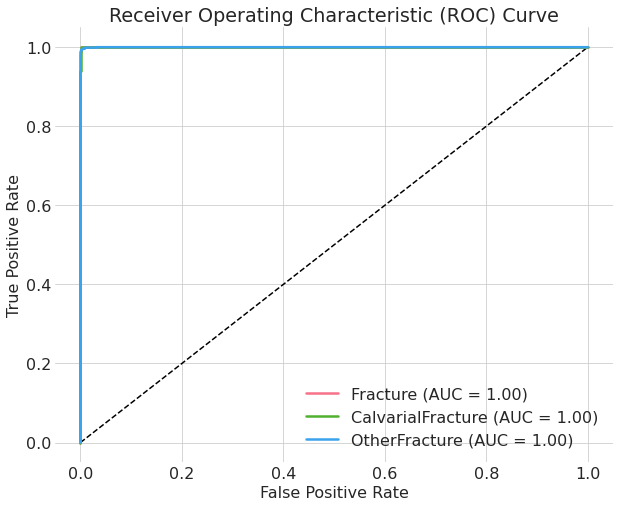

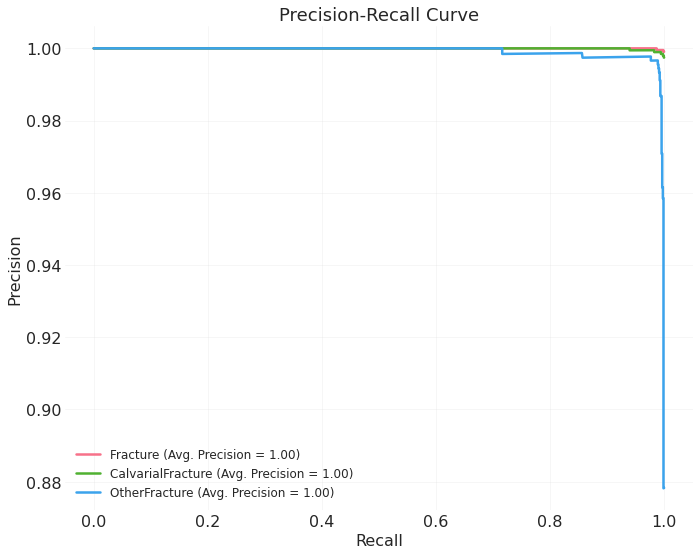

In [43]:
plot_visualizer = PlotVisualizer(LABEL_COLS, PLOT_SAVE_PATH)
plot_visualizer.plot_multilabel_confusion_matrix(true_labels, predictions)
plot_visualizer.plot_roc_curve(true_labels, probabilities)
plot_visualizer.plot_precision_recall_curve(true_labels, probabilities)

***GRADCAM HeatMap Generation***

In [44]:
# # Sample reload example


# import results.heatmap_generator
# import importlib
# importlib.reload(results.heatmap_generator)
# from results.heatmap_generator import HeatmapGenerator
# generator = HeatmapGenerator(model_predictor, TEST_CSV_FILE, MODEL, SIZE, DATASET_PATH, CAM_OUTPUT_SIZE, GRADCAM_HEATMAP_SAVE_PATH, modelName)

# generator.plot_heatmaps()


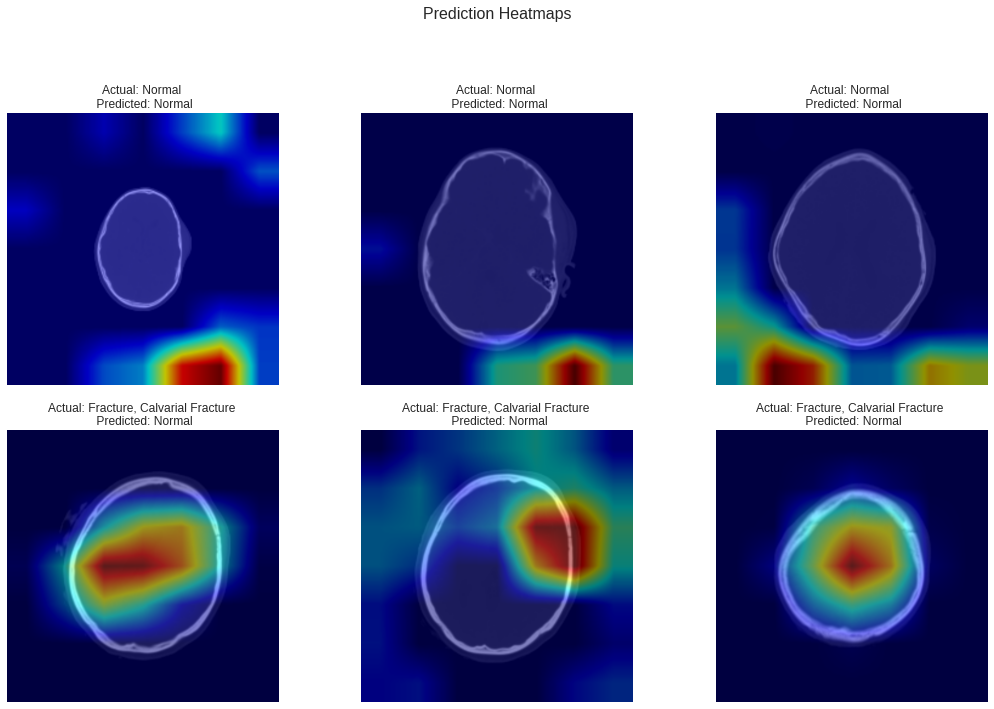

In [45]:
generator = HeatmapGenerator(model_predictor, TEST_CSV_FILE, MODEL, SIZE, DATASET_PATH, CAM_OUTPUT_SIZE, GRADCAM_HEATMAP_SAVE_PATH, modelName)

generator.plot_heatmaps()